In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

from gbgpu.gbgpu import GBGPU
from gbgpu.utils.constants import *
from gbgpu.utils.utility import *

from bbhx.waveformbuild import BBHWaveformFD

from bbhx.utils.constants import *

import ldc.waveform.fastGB as fastGB 
from ldc.lisa.orbits import Orbits

from lisabeta.lisa.lisa import GenerateLISATDISignal_SMBH, EvaluateTDIFreqseries

/Users/michaelkatz/anaconda3/envs/tut_env/lib/python3.7/site-packages/gbgpu-0.1-py3.7-macosx-10.9-x86_64.egg/gbgpu/gbgpu.py:24: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")
/Users/michaelkatz/anaconda3/envs/tut_env/lib/python3.7/site-packages/gbgpu-0.1-py3.7-macosx-10.9-x86_64.egg/gbgpu/utils/utility.py:15: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")


No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


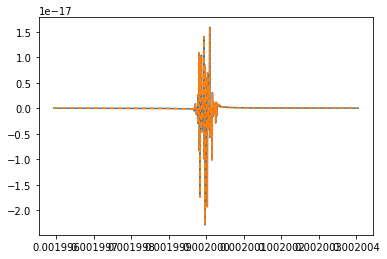

In [19]:
dt = 10.0
Tobs = 4.0 * YEAR


# number of points in waveform
# if None, will determine inside the code based on amp, f0 (and P2 if running third-body waveform)
N = None

# number of binaries to batch
num_bin = 10

# parameters
amp = 2e-23  # amplitude
f0 = 2e-3  # f0
fdot = 7.538331e-18  # fdot
fddot = 0.0 # fddot
phi0 = 0.1  # initial phase
iota = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta_sky = 0.5  # ecliptic latitude


# for batching
amp_in = np.full(num_bin, amp)
f0_in = np.full(num_bin, f0)
fdot_in = np.full(num_bin, fdot)
fddot_in = np.full(num_bin, fddot)
phi0_in = np.full(num_bin, phi0)
iota_in = np.full(num_bin, iota)
psi_in = np.full(num_bin, psi)
lam_in = np.full(num_bin, lam)
beta_sky_in = np.full(num_bin, beta_sky)

params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

tmax = Tobs # df is 1/tmax or 1/len(tdi.X)

orbits = Orbits.type(dict({'orbit_type':'analytic', 'nominal_arm_length':2.5e9, # or cfg["nominal_arm_length"]
                           "initial_position": 0, "initial_rotation": 0}))

GB = fastGB.FastGB(delta_t=dt, T=tmax, orbits=orbits)
gb = GBGPU(use_gpu=False)

Xs, Ys, Zs = GB.get_fd_tdixyz(f0=params[1, 0], fdot=params[2, 0], ampl=params[0, 0],
                      theta=np.pi / 2 - params[8, 0], phi=params[7, 0], psi=params[6, 0], incl=params[5, 0], phi0=params[4, 0], oversample=4)

gb.run_wave(*params, dt=dt, T=Tobs, oversample=4)
A_gbgpu = gb.A[0]
E_gbgpu = gb.E[0]
f_gbgpu = gb.freqs[0]

As, Es, Ts = AET(Xs, Ys, Zs)

plt.plot(As.f, As)
#plt.plot(f_gbgpu, A_gbgpu.real)
plt.plot(f_gbgpu, A_gbgpu.real, '--')

In [21]:
1- np.dot(As.conj(), A_gbgpu) / np.sqrt(np.dot(As.conj(), As) * np.dot(A_gbgpu.conj(), A_gbgpu))

(7.771561172376096e-16-4.123152468287838e-10j)

In [10]:
wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=True))

In [11]:
fRef = 0.0
phi0 = 0.0
m1 = 4615384.615384615
m2 = 1384615.3846153845
a1 = 0.5
a2 = 0.2
dist = 6791.810623950793
inc = 1.0471975511965976
beta = 1.0471975511965976
lam = 0.7853981633974483
psi = 0.7853981633974483
tRef = 1.0 * YRSID_SI

freq = np.logspace(-4, 0, 1024)
freq_new = np.logspace(-4, 1, 100000)
modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]

lb_params = dict(m1=m1,               # Redshifted mass of body 1 (solar masses)
        m2=m2,               # Redshifted mass of body 2 (solar masses)
        chi1=a1,             # Dimensionless spin of body 1 (in [-1, 1])
        chi2=a2,             # Dimensionless spin of body 2 (in [-1, 1])
        Deltat=tRef,           # Time shift (s)
        dist=dist,             # Luminosity distance (Mpc)
        inc=inc,              # Inclination angle (rad)
        phi=phi0,              # Observer's azimuthal phase (rad)
        beta=beta,             # Source latitude (rad)
        psi=psi)
lb_params['lambda'] = lam

katz_params = [m1,               # Redshifted mass of body 1 (solar masses)
        m2,               # Redshifted mass of body 2 (solar masses)
        a1,             # Dimensionless spin of body 1 (in [-1, 1])
        a2,             # Dimensionless spin of body 2 (in [-1, 1])
        dist * 1e6 * PC_SI,             # Luminosity distance (Mpc)
        phi0,              # Observer's azimuthal phase (rad)
        fRef,
        inc,              # Inclination angle (rad)
        lam,           # Source longitude (rad)
        beta,             # Source latitude (rad)
        psi,
        tRef,] 
        #tRef,]          # Time shift (s)  


#Orbits initialization
import lisabeta.lisa.pyresponse as pyresponse
lisa_params = pyresponse.LISAconstDict["Proposal"]


katz_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))



In [13]:
Tobs_yr = 1.2 * YRSID_SI

wvf_pars = {
            "minf": 1e-5,  "maxf": 0.1,
            "timetomerger_max": 1.0,
            "fend": None, "tmin": None, "tmax": Tobs_yr,
            "TDI": "TDIAET", "acc": 1e-4,
            "order_fresnel_stencil": 0,
            "LISAconst": lisa_params,
            "responseapprox": "full",
            "frozenLISA": False,
            "TDIrescaled": False,
            #"DeltatL_cut": YRSID_SI, # - 3600.00,
			'scale_freq_hm': True
        }

lb_temp = GenerateLISATDISignal_SMBH(lb_params, modes=[(2, 2)], approximant='IMRPhenomD', tf_method='analytical', **wvf_pars)

#np.intersect1d(freq_new_mode)

lb_wave_all = np.conj(EvaluateTDIFreqseries(lb_temp['tdi'], freq_new)[(2, 2)]['chan1'])

katz_wave_all = wave_gen(*katz_params,
        freqs=freq_new,
	modes=[(2,2)], direct=False, length=1024, fill=True, t_obs_end=0.0)[0, 0] 

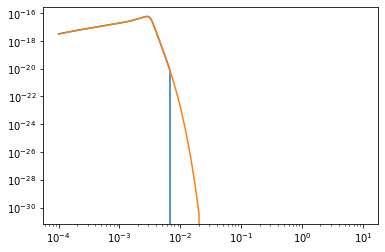

In [16]:
plt.loglog(freq_new, np.abs(lb_wave_all))
plt.loglog(freq_new, np.abs(katz_wave_all))

In [19]:
1- np.dot(lb_wave_all.conj(), katz_wave_all) / np.sqrt(np.dot(lb_wave_all.conj(), lb_wave_all) * np.dot(katz_wave_all.conj(), katz_wave_all))

(5.292802862655321e-10+1.9907133892121623e-08j)

/Users/michaelkatz/anaconda3/envs/tut_env/lib/python3.7/site-packages/few-1.4.6-py3.7-macosx-10.9-x86_64.egg/few/utils/utility.py:776: UserWarning: The file FluxNewMinusPNScaled_fixed_y_order.dat did not open sucessfully. It will now be downloaded to the proper location.
  fp
--2022-07-25 00:24:58--  https://zenodo.org/record/3981654/files/FluxNewMinusPNScaled_fixed_y_order.dat
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61494 (60K) [application/octet-stream]
Saving to: ‘FluxNewMinusPNScaled_fixed_y_order.dat’

     0K .......... .......... .......... .......... .......... 83% 1000K 0s
    50K ..........                                            100% 98.2M=0.05s

2022-07-25 00:25:00 (1.17 MB/s) - ‘FluxNewMinusPNScaled_fixed_y_order.dat’ saved [61494/61494]

/Users/michaelkatz/anaconda3/envs/tut_env/lib/python3.7/site-packages/few-1.4.6-py3.7-macosx-10.9-

  5800K .......... .......... .......... .......... .......... 46% 5.54M 1s
  5850K .......... .......... .......... .......... .......... 46% 15.9M 1s
  5900K .......... .......... .......... .......... .......... 47% 2.23M 1s
  5950K .......... .......... .......... .......... .......... 47% 7.40M 1s
  6000K .......... .......... .......... .......... .......... 48% 12.2M 1s
  6050K .......... .......... .......... .......... .......... 48% 8.63M 1s
  6100K .......... .......... .......... .......... .......... 48% 16.7M 1s
  6150K .......... .......... .......... .......... .......... 49% 5.44M 1s
  6200K .......... .......... .......... .......... .......... 49% 14.0M 1s
  6250K .......... .......... .......... .......... .......... 50% 5.68M 1s
  6300K .......... .......... .......... .......... .......... 50% 28.0M 1s
  6350K .......... .......... .......... .......... .......... 50% 7.28M 1s
  6400K .......... .......... .......... .......... .......... 51% 14.3M 1s
  6450K ....

 11850K .......... .......... .......... .......... .......... 94%  851K 0s
 11900K .......... .......... .......... .......... .......... 94% 11.0M 0s
 11950K .......... .......... .......... .......... .......... 95% 3.21M 0s
 12000K .......... .......... .......... .......... .......... 95% 12.4M 0s
 12050K .......... .......... .......... .......... .......... 96% 13.3M 0s
 12100K .......... .......... .......... .......... .......... 96% 14.7M 0s
 12150K .......... .......... .......... .......... .......... 96% 15.4M 0s
 12200K .......... .......... .......... .......... .......... 97% 2.56M 0s
 12250K .......... .......... .......... .......... .......... 97% 34.1M 0s
 12300K .......... .......... .......... .......... .......... 98% 28.2M 0s
 12350K .......... .......... .......... .......... .......... 98% 11.6M 0s
 12400K .......... .......... .......... .......... .......... 98% 11.0M 0s
 12450K .......... .......... .......... .......... .......... 99% 9.53M 0s
 12500K ....

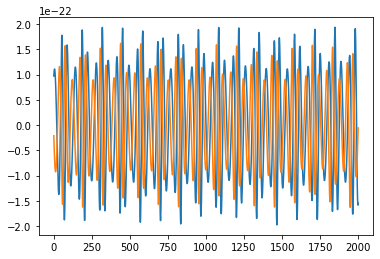

In [21]:
from few.waveform import GenerateEMRIWaveform

gen_wave_rel = GenerateEMRIWaveform("FastSchwarzschildEccentricFlux")
gen_wave_aak = GenerateEMRIWaveform("Pn5AAKWaveform")

# parameters
T = 0.01  # years
dt = 15.0  # seconds
M = 1e6
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 1e1
p0 = 12.0
e0 = 0.2
x0 = 0.8  # will be ignored in Schwarzschild waveform
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
dist = 1.0  # distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

h_rel = gen_wave_rel(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

h_aak = gen_wave_aak(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

plt.plot(h_rel.real[:2000])
plt.plot(h_aak.real[:2000])